# Control using the Koopman operator

This example demonstrates Koopman LQR control using a Van der Pol oscillator.

In [1]:
# Imports
import control
import numpy as np
from matplotlib import pyplot as plt

import pykoop

# Set plot defaults
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

Load example data from the library. `eg` is a `dict` containing training data, validation data, and a few related parameters.

In [2]:
eg = pykoop.example_data_vdp()

Create Koopman pipelines with linear and polynomial lifting functions.

In [3]:
kp_lin = pykoop.KoopmanPipeline(
    lifting_functions=None,
    regressor=pykoop.Edmd(),
).fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)

kp_poly = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'sp',
        pykoop.SplitPipeline(
            lifting_functions_state=[
                ('pl', pykoop.PolynomialLiftingFn(order=3))
            ],
            lifting_functions_input=None,
        ),
    )],
    regressor=pykoop.Edmd(),
).fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)

Extract state-space matrices from Koopman matrix.

In [4]:
U_lin = kp_lin.regressor_.coef_.T
A_lin = U_lin[:, :U_lin.shape[0]]
B_lin = U_lin[:, U_lin.shape[0]:]
U_poly = kp_poly.regressor_.coef_.T
A_poly = U_poly[:, :U_poly.shape[0]]
B_poly = U_poly[:, U_poly.shape[0]:]

Synthesize linear and Koopman LQR controllers.

In [5]:
Q_lin = np.eye(2)
R_lin = np.eye(1)
Q_poly = np.diag([1, 1, 0, 0, 0, 0, 0, 0, 0])
R_poly = np.eye(1)

K_lin, _, _ = control.dlqr(A_lin, B_lin, Q_lin, R_lin, method='scipy')
K_poly, _, _ = control.dlqr(A_poly, B_poly, Q_poly, R_poly, method='scipy')

Set number of prediciton timesteps and get dynamic model.

In [6]:
N = 1000
vdp = eg['dynamic_model']

Run prediction without controller.

In [7]:
Xc_gt = np.zeros((N, 2))
Xc_gt[0, :] = np.array([1, 1])
for k in range(1, N):
    Xc_gt[k, :] = vdp.f(0, Xc_gt[k - 1, :], 0)

Run prediction with linear controller.

In [8]:
Xc_lin = np.zeros((N, 2))
Uc_lin = np.zeros((N, 1))
Xc_lin[0, :] = np.array([1, 1])
for k in range(1, N):
    Uc_lin[[k - 1], :] = (-K_lin @ Xc_lin[[k - 1], :].T).T
    Xc_lin[k, :] = vdp.f(0, Xc_lin[k - 1, :], Uc_lin[k - 1, :].item())

Run prediction with Koopman controller.

In [9]:
Xc_poly = np.zeros((N, 2))
Uc_poly = np.zeros((N, 1))
Xc_poly[0, :] = np.array([1, 1])
for k in range(1, N):
    lifted_state = kp_poly.lift_state(
        Xc_poly[[k - 1], :],
        episode_feature=False,
    )
    Uc_poly[[k - 1], :] = (-K_poly @ lifted_state.T).T
    Xc_poly[k, :] = vdp.f(0, Xc_poly[k - 1, :], Uc_poly[k - 1, :].item())

Plot trajectories.

Text(0.5, 1.0, 'Comparison of linear and Koopman LQR controllers')

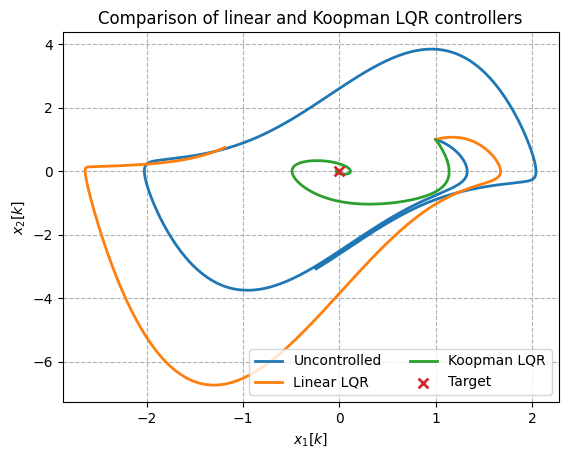

In [10]:
fig, ax = plt.subplots()
ax.plot(Xc_gt[:, 0], Xc_gt[:, 1], label='Uncontrolled')
ax.plot(Xc_lin[:, 0], Xc_lin[:, 1], label='Linear LQR')
ax.plot(Xc_poly[:, 0], Xc_poly[:, 1], label='Koopman LQR')
ax.scatter([0], [0], s=50, c='C3', zorder=2, marker='x', label='Target')
ax.set_xlabel('$x_1[k]$')
ax.set_ylabel('$x_2[k]$')
ax.legend(loc='lower right', ncol=2)
ax.set_title('Comparison of linear and Koopman LQR controllers')